# Networked and Distributed Control Systems Assignment 4 
### Henry Adam
### Distributed Optimization and Multi-Agent Rendezvous

# Part 0: Initialization


In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt 

#Declaring initial variables(copied from agents.m)
#Agent 1: 
# plot starting positions of agents
A1 = np.array([[0.626, -0.6975], 
               [0.8719, 0.626]])
B1 = np.array([[-0.0748],
               [ 0.1744]])
x01 = np.array([[-10.0],
                [ -0.5 ]])

#Agent 2: 
A2 = np.array([[0.626,  -0.6975],
               [0.8719,  0.626 ]])
B2 = np.array([[-0.0748],
               [ 0.1744]])
x02 = np.array([[-1.0],
                [ 1.0 ]])

#Agent 3: 
A3 = np.array([[0.626,  -0.6975],
               [0.8719,  0.626 ]])
B3 = np.array([[-0.0748],
               [ 0.1744]])
x03 = np.array([[ 2.0],
                [ 0.0 ]])
#Agent 4: 
A4 = np.array([[0.626,  -0.6975],
               [0.8719,  0.626 ]])
B4 = np.array([[-0.0748],
               [ 0.1744]])
x04 = np.array([[ 5.0],
                [ -0.5 ]])


A_list = [A1, A2, A3, A4]
B_list = [B1, B2, B3, B4]
init_x_list = [x01, x02, x03, x04]

Tfinal = 20
umax   = 7 
n_agents = 4

# Question 1: 

### Part A: 
Derive a solution based on dual decomposition using the projected subgradient method and demonstrate it with the use of Matlab or Python (use of cvx toolbox is allowed). 

Show a plot that demonstrates the convergence of the optimization process (in terms of a logarithmic error sequence). 

Show a plot of the resulting agent state trajectories after convergence, and compare with the centralized optimal solution.

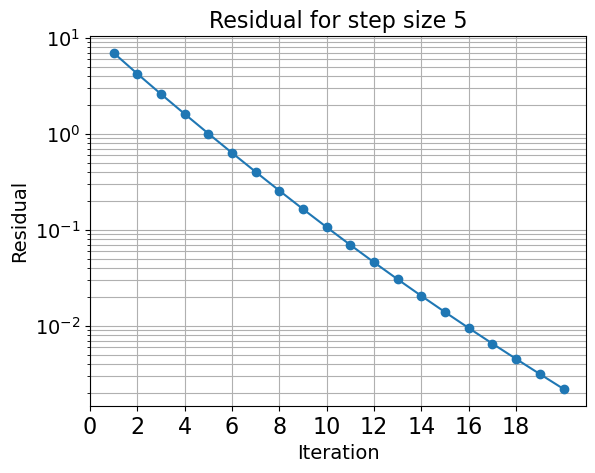

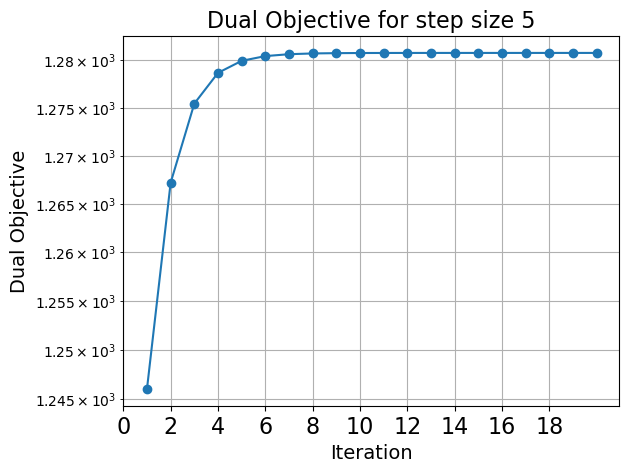

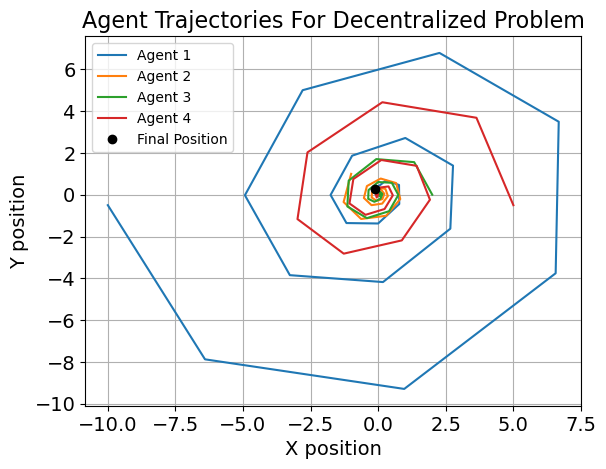

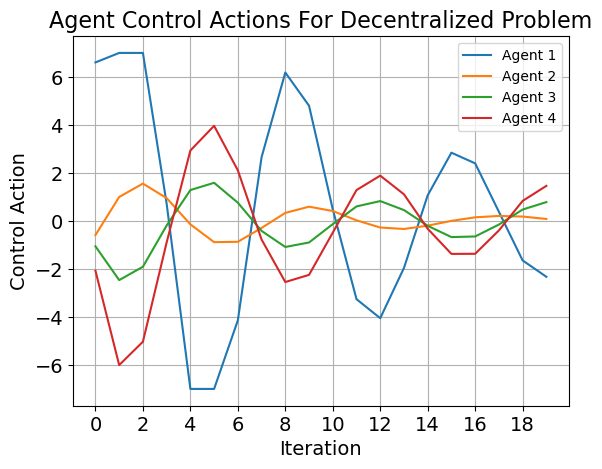

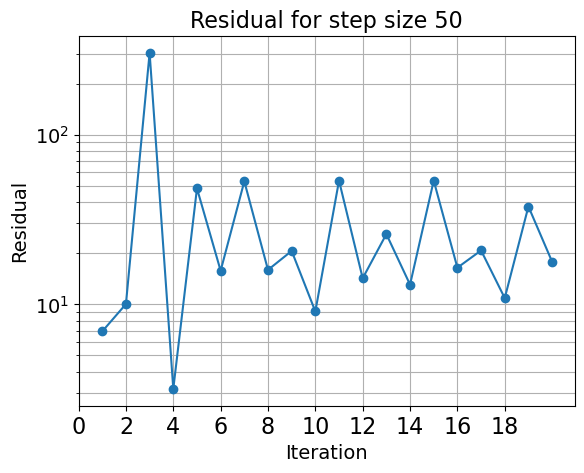

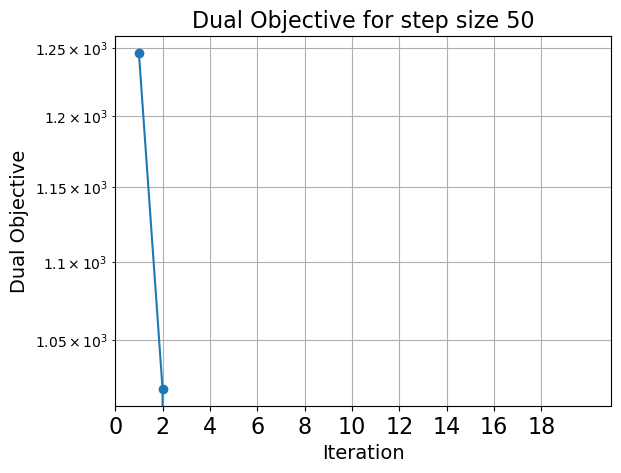

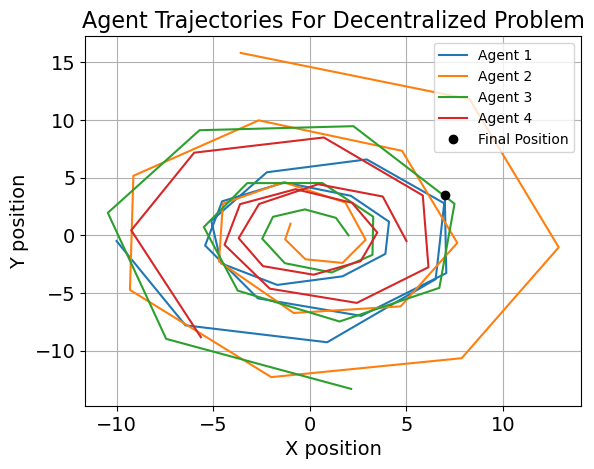

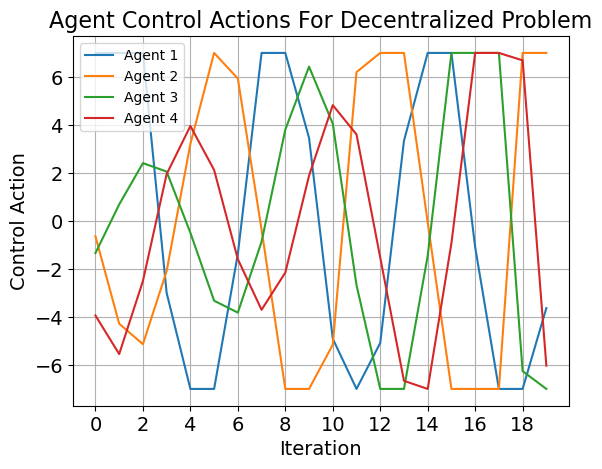

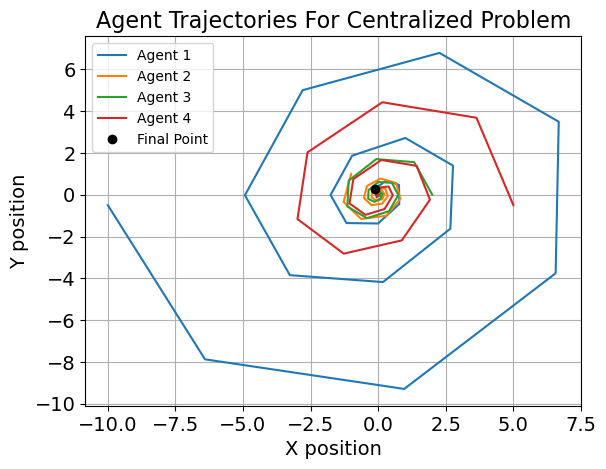

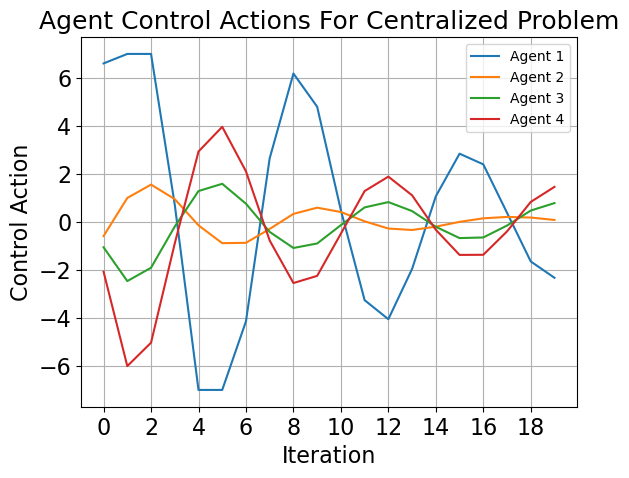

1280.7463588050014


In [2]:
# Use Dual Decomposition/Subgradient Method for Distributed Optimization
def dual_subgradient_optimize(alpha=0.1, stop_condition=1e-3, plot_convergence=True, plot_trajectories=True, diminishing_step=False):
    #initialize the lambda values and the xf at zero 
    lambdas = [np.zeros(np.shape(x01)) for _ in range(n_agents)]
    #xf = np.zeros(np.shape(x01))
    xf = np.array([[(x01[0] + x02[0] +x03[0] +x04[0])/4],[(x01[1] + x02[1] +x03[1] +x04[1])/4]])

    #variables for data storage
    residuals = np.zeros((1, Tfinal))
    dual_objs = np.zeros((1, Tfinal))
    
    #iterate over all timesteps
    for k in range(Tfinal): 
        
        #Variables we want to save for each agent @ each iteration 
        xf_list = np.zeros((np.size(xf),4))
        dual_obj = 0
        #iterate over all agents 
        for agent_i in range(n_agents):
            #solve the subproblem for the particular agent
            lambda_i = lambdas[agent_i]
            u_i_sub, x_i_sub, xf_sub = solve_subproblem(agent_i, xf, lambda_i, Tfinal)

            #update the list variables
            xf_list[:, agent_i] = xf_sub 

            # Calculate the dual objective for the particular agent
            for t in range(Tfinal): 
                dual_obj += u_i_sub[:, t].T @ u_i_sub[:, t]
            for t in range(Tfinal): 
                dual_obj += x_i_sub[:, t].T @ x_i_sub[:, t]
            dual_obj += lambda_i.T @ xf_sub

        #updae the xf variable

        xf = np.mean(xf_list, 1) #mean across collumns
        #now update the residual 
        #residual = np.max([np.abs(xf_list[:,xf_i] - xf) for xf_i in range(np.size(xf_list, 1))])
        residual = np.max([np.linalg.norm(xf_list[:,xf_i] - xf)/np.linalg.norm(xf) for xf_i in range(np.size(xf_list, 1))])

        residuals[:, k] = residual

        if residual <= stop_condition:

            break 

        #and log it: 
        dual_objs[:, k] = dual_obj

        #find the updated lambda for each agent
        lambda1_sums = 0
        lambda2_sums = 0

        if diminishing_step: 
            if k == 0: 
                alpha_i = alpha
            else:
                alpha_i = alpha / k
            for i in range(n_agents):
                g_i = (xf_list[:, i].reshape((2,1)) - xf.reshape((2,1)))  #Subgradient of dual problem
                lambdas[i] = lambdas[i] + alpha_i * g_i #update lambda w/ changing step size

        else: 
            for i in range(n_agents):
                g_i = xf_list[:, i].reshape((2,1)) #- xf.reshape((2,1)) #Subgradient of dual problem
                lambdas[i] = lambdas[i] + alpha * g_i #update lambda (Note that because we are maximizing this problem, it's gradient ascent)

                #save some variables for projection onto the feasible set
                lambda1_sums += lambdas[i][0]
                lambda2_sums += lambdas[i][1]

        #Project the lambda back onto the possible values (sum of lambdas must be zero for each component of lambda)
        for l_idx in range(n_agents):
            lambdas[l_idx][0] -= lambda1_sums/n_agents
            lambdas[l_idx][1] -= lambda2_sums/n_agents
            
        #Double check that all the lambdas sum to 0 
        #print("Sum of Lambdas is: ", lambdas[0] + lambdas[1] +lambdas[2] +lambdas[3])

    #plot convergence results 
    if plot_convergence: 
        # Logarithmic error sequence for residuals
        plt.figure()
        plt.semilogy(np.arange(1, k+2), residuals.flatten()[:k+1], marker='o')
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Residual', fontsize=14)
        plt.title(f'Residual for step size {alpha}', fontsize=16)
        plt.grid(True, which='both', axis='both')
        plt.xticks(np.arange(0, Tfinal, 2), fontsize=16)
        plt.yticks(fontsize=14)
        plt.savefig(f"dual_decomp_residual_alpha{alpha}.pdf", format="pdf")
        plt.show()

        # Logarithmic error sequence for dual objective
        plt.figure()
        plt.semilogy(np.arange(1, k+2), dual_objs.flatten()[:k+1], marker='o')
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Dual Objective', fontsize=14)
        plt.title(f'Dual Objective for step size {alpha}', fontsize=16)
        plt.grid(True, which='both', axis='both')
        plt.xticks(np.arange(0, Tfinal, 2), fontsize=16)
        plt.yticks(fontsize=14)
        plt.savefig(f"dual_decomp_dualObj_alpha{alpha}.pdf", format="pdf")
        plt.show()

    #recreate the trajectories using the lambdas: 
    ui_1, x_i_1, _ = solve_subproblem(0, xf, lambdas[0], Tfinal)
    ui_2, x_i_2, _ = solve_subproblem(1, xf, lambdas[1], Tfinal)
    ui_3, x_i_3, _ = solve_subproblem(2, xf, lambdas[2], Tfinal)
    ui_4, x_i_4, _ = solve_subproblem(3, xf, lambdas[3], Tfinal)

    if plot_trajectories: 
        # static plot of trajectories
        plt.figure()
        plt.plot(x_i_1[0, :], x_i_1[1, :], label='Agent 1') #, marker='o'
        plt.plot(x_i_2[0, :], x_i_2[1, :], label='Agent 2') # , marker='s'
        plt.plot(x_i_3[0, :], x_i_3[1, :], label='Agent 3') # , marker='^'
        plt.plot(x_i_4[0, :], x_i_4[1, :], label='Agent 4') # , marker='x'
        plt.plot(x_i_1[0, -1], x_i_1[1, -1], 'ko', label='Final Position')
        plt.xlabel('X position', fontsize=14)
        plt.ylabel('Y position', fontsize=14)
        plt.title('Agent Trajectories For Decentralized Problem', fontsize=16)
        plt.legend()
        plt.grid(True)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.savefig(f"dual_decomp_traj_alpha{alpha}.pdf", format="pdf")
        plt.show()

        plt.figure()
        #print(np.size(ui_1))
        plt.plot(np.arange(0,np.size(ui_1)), ui_1[0, :], label='Agent 1') #, marker='o'
        plt.plot(np.arange(0,np.size(ui_2)), ui_2[0, :], label='Agent 2') # , marker='s'
        plt.plot(np.arange(0,np.size(ui_3)), ui_3[0, :], label='Agent 3') # , marker='^'
        plt.plot(np.arange(0,np.size(ui_4)), ui_4[0, :], label='Agent 4') # , marker='x'
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Control Action', fontsize=14)
        plt.title('Agent Control Actions For Decentralized Problem', fontsize=16)
        plt.legend()
        plt.grid(True)
        plt.xticks(np.arange(0, Tfinal, 2), fontsize=14)
        plt.yticks(fontsize=14)
        plt.savefig(f"dual_decomp_ctrl_alpha{alpha}.pdf", format="pdf")
        plt.show()

    return k, residuals.flatten()[:k+1], dual_objs.flatten()[:k+1], np.array([ui_1, ui_2, ui_3, ui_4]), np.array([x_i_1, x_i_2, x_i_3, x_i_4])

def solve_subproblem(i, xf, lambda_i, Tf):
    #make sure you have all the right dynamics variables
    A_i = A_list[i]
    B_i = B_list[i]
    x0_i = init_x_list[i]

    #Decision Variables
    u_i = cvx.Variable((np.size(B1,1), Tf))
    x_i = cvx.Variable((np.size(A1,1), Tf + 1))

    #add constraints
    constraints = []
    #constraint 0: Start @ initial position
    constraints.append(x_i[:,0].reshape(np.shape(x0_i)) == x0_i)

    #constraint 1: x_k+1 = Ax_k + Bu_k 
    #Loop through all of the timesteps
    for k in range(Tf):
        constraints.append(x_i[:,k+1] == A_i @ x_i[:,k] + B_i @ u_i[:, k])
    
    #constraint 2: |u_k| < u_max
    for k in range(Tf):
        constraints.append(cvx.abs(u_i[:,k]) <= umax)

    #add objective function: 
    obj = 0
    for k in range(Tf):
        obj += cvx.sum_squares(x_i[:, k])
        obj += cvx.sum_squares(u_i[:, k])
    
    #add lagrangian(dual) term to obj 
    #print(lambda_i)
    #print(x_i[:,Tf])
    obj += lambda_i.T @ (x_i[:, Tf].reshape((2,1)) - xf.reshape((2,1)))

    prob = cvx.Problem(cvx.Minimize(obj), constraints=constraints)
    prob.solve(solver=cvx.OSQP, verbose=False) #there are a bunch of arguments you can use with this 
    
    if prob.status == cvx.OPTIMAL:
        return u_i.value, x_i.value, x_i[:, Tf].value
    else: 
        print(f"SUBPROBLEM SOLUTION WAS NOT OPTIMAL FOR AGENT {i} using {xf}, {lambda_i}")
        return None, None, None

_, _, _, _, _ = dual_subgradient_optimize(alpha=5, stop_condition=1e-6)
_, _, _, _, _ = dual_subgradient_optimize(alpha=50, stop_condition=1e-6)

# Get the Centralized Optimal Solution: 
def solve_centralized(plot_trajectories=True):
    #simple centralized solution to the problem: 

    x_f = cvx.Variable((np.size(A1,1), 1))  # Terminal state is an optimization variable
    #Declare all of the optimization variables 
    #For agent 1
    u_i_1 = cvx.Variable((np.size(B1,1), Tfinal))
    x_i_1 = cvx.Variable((np.size(A1,1), Tfinal + 1))

    #For agent 2
    u_i_2 = cvx.Variable((np.size(B1,1), Tfinal))
    x_i_2 = cvx.Variable((np.size(A1,1), Tfinal + 1))

    #For agent 3
    u_i_3 = cvx.Variable((np.size(B1,1), Tfinal))
    x_i_3 = cvx.Variable((np.size(A1,1), Tfinal + 1))

    #For agent 4
    u_i_4 = cvx.Variable((np.size(B1,1), Tfinal))
    x_i_4 = cvx.Variable((np.size(A1,1), Tfinal + 1))


    #create constraints: 
    constraints = []
    #Constraint 0: Starting position 
    constraints.append(x_i_1[:,0].reshape(np.shape(x01)) == x01)
    constraints.append(x_i_2[:,0].reshape(np.shape(x02)) == x02)
    constraints.append(x_i_3[:,0].reshape(np.shape(x03)) == x03)
    constraints.append(x_i_4[:,0].reshape(np.shape(x04)) == x04)

    #Constraint 1: Dynamics Constraints: 
    for k in range(Tfinal): 
        constraints.append(x_i_1[:, k+1] == A1 @ x_i_1[:,k] + B1 @ u_i_1[:, k])
        constraints.append(x_i_2[:, k+1] == A2 @ x_i_2[:,k] + B2 @ u_i_2[:, k])
        constraints.append(x_i_3[:, k+1] == A3 @ x_i_3[:,k] + B3 @ u_i_3[:, k])
        constraints.append(x_i_4[:, k+1] == A4 @ x_i_4[:,k] + B4 @ u_i_4[:, k])
    
    # Constraint 2: Max Control Torque 
    for k in range(Tfinal):
        constraints.append(cvx.abs(u_i_1[:,k]) <= umax)
        constraints.append(cvx.abs(u_i_2[:,k]) <= umax)
        constraints.append(cvx.abs(u_i_3[:,k]) <= umax)
        constraints.append(cvx.abs(u_i_4[:,k]) <= umax)

    # Constraint 3: Final Position
    constraints.append(x_i_1[:,Tfinal].reshape(np.shape(x01)) == x_f)
    constraints.append(x_i_2[:,Tfinal].reshape(np.shape(x02)) == x_f)
    constraints.append(x_i_3[:,Tfinal].reshape(np.shape(x03)) == x_f)
    constraints.append(x_i_4[:,Tfinal].reshape(np.shape(x04)) == x_f)

    #Objective Function: 
    obj = 0 
    for k in range(Tfinal): 
        obj += cvx.sum_squares(x_i_1[:,k])
        obj += cvx.sum_squares(x_i_2[:,k])
        obj += cvx.sum_squares(x_i_3[:,k])
        obj += cvx.sum_squares(x_i_4[:,k])
        obj += cvx.sum_squares(u_i_1[:,k])
        obj += cvx.sum_squares(u_i_2[:,k])
        obj += cvx.sum_squares(u_i_3[:,k])
        obj += cvx.sum_squares(u_i_4[:,k])
    
    prob = cvx.Problem(cvx.Minimize(obj), constraints=constraints)
    prob.solve(solver=cvx.OSQP, verbose=False) #there are a bunch of arguments you can use with this 

    if prob.status == cvx.OPTIMAL:
        #Agent 1
        u_i_1_final = u_i_1.value
        x_i_1_final = x_i_1.value

        #Agent 2
        u_i_2_final = u_i_2.value
        x_i_2_final = x_i_2.value

        #Agent 3
        u_i_3_final = u_i_3.value
        x_i_3_final = x_i_3.value

        #Agent 4
        u_i_4_final = u_i_4.value
        x_i_4_final = x_i_4.value

        #Final Value: 
        x_final = x_f.value

        cost = prob.value
    else:
        cost = None
        print(f"CENTRALIZED SOLUTION WAS NOT OPTIMAL!!!")
    
    if plot_trajectories: 
        plt.figure()
        plt.plot(x_i_1_final[0, :], x_i_1_final[1, :], label='Agent 1') #, marker='o'
        plt.plot(x_i_2_final[0, :], x_i_2_final[1, :], label='Agent 2') # , marker='s'
        plt.plot(x_i_3_final[0, :], x_i_3_final[1, :], label='Agent 3') # , marker='^'
        plt.plot(x_i_4_final[0, :], x_i_4_final[1, :], label='Agent 4') # , marker='x'
        plt.plot(x_i_4_final[0, -1], x_i_4_final[1, -1], 'ko', label='Final Point') # , marker='x'
        plt.xlabel('X position', fontsize=14)
        plt.ylabel('Y position', fontsize=14)
        plt.title('Agent Trajectories For Centralized Problem', fontsize=16)
        plt.legend()
        plt.grid(True)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.savefig(f"centralized_traj.pdf", format="pdf")
        plt.show()
        

        plt.figure()
        plt.plot(np.arange(0,Tfinal), u_i_1_final[0, :], label='Agent 1') #, marker='o'
        plt.plot(np.arange(0,Tfinal), u_i_2_final[0, :], label='Agent 2') # , marker='s'
        plt.plot(np.arange(0,Tfinal), u_i_3_final[0, :], label='Agent 3') # , marker='^'
        plt.plot(np.arange(0,Tfinal), u_i_4_final[0, :], label='Agent 4') # , marker='x'
        plt.xlabel('Iteration', fontsize=16)
        plt.ylabel('Control Action', fontsize=16)
        plt.title('Agent Control Actions For Centralized Problem', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.xticks(np.arange(0, Tfinal, 2), fontsize=16)
        plt.yticks(fontsize=16)
        plt.savefig(f"centralized_ctrl.pdf", format="pdf")
        plt.show()
    
    return cost

optimal_cost = solve_centralized()
print(optimal_cost)

### Part B: 
Investigate the effect of step size (for constant step) and step size update sequence (for variable step) on the convergence of the standard subgradient method. 

Show the results using a logarithmic error sequence plot.

In [3]:
alpha1 = 1
alpha2 = 5
alpha3 = 10
alpha4 = 20
alpha5 = 50

k_final1, residuals1_cs, dual_costs1_cs, _, _ = dual_subgradient_optimize(alpha=alpha1, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_final2, residuals2_cs, dual_costs2_cs, _, _ = dual_subgradient_optimize(alpha=alpha2, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_final3, residuals3_cs, dual_costs3_cs, _, _ = dual_subgradient_optimize(alpha=alpha3, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_final4, residuals4_cs, dual_costs4_cs, _, _ = dual_subgradient_optimize(alpha=alpha4, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_final5, residuals5_cs, dual_costs5_cs, _, _ = dual_subgradient_optimize(alpha=alpha5, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)


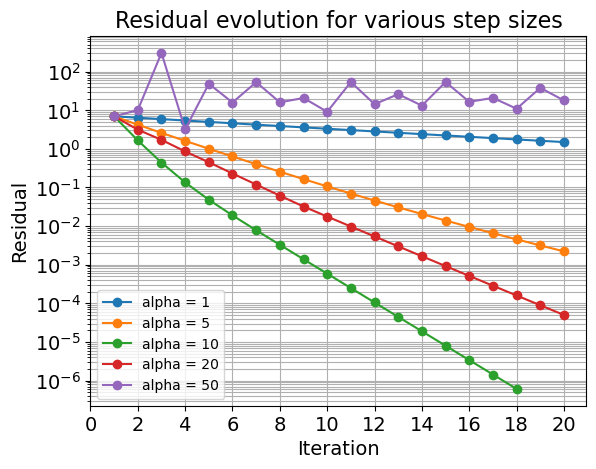

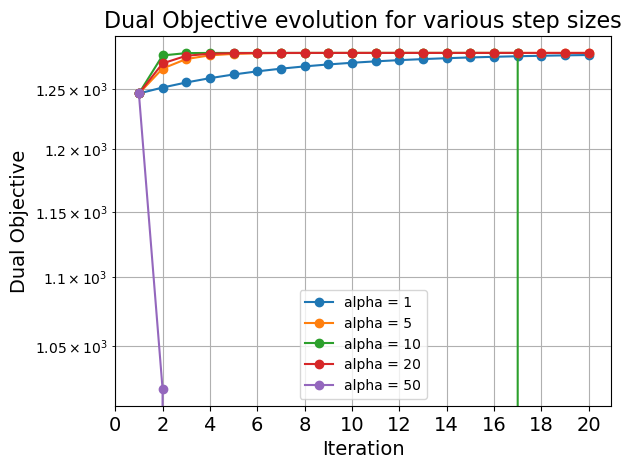

In [4]:
# Logarithmic error sequence for residuals
plt.figure()
plt.semilogy(np.arange(1, k_final1+2), residuals1_cs, marker='o', label=f"alpha = {alpha1}")
plt.semilogy(np.arange(1, k_final2+2), residuals2_cs, marker='o', label=f"alpha = {alpha2}")
plt.semilogy(np.arange(1, k_final3+2), residuals3_cs, marker='o', label=f"alpha = {alpha3}")
plt.semilogy(np.arange(1, k_final4+2), residuals4_cs, marker='o', label=f"alpha = {alpha4}")
plt.semilogy(np.arange(1, k_final5+2), residuals5_cs, marker='o', label=f"alpha = {alpha5}")
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title(f'Residual evolution for various step sizes', fontsize=16)
plt.xticks(np.arange(0, Tfinal+1, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(True, which='both', axis='both')
plt.savefig(f"classical_residual_comparison.pdf", format="pdf")
plt.show()

# Logarithmic error sequence for dual objective
plt.figure()
plt.semilogy(np.arange(1, k_final1+2), dual_costs1_cs, marker='o', label=f"alpha = {alpha1}")
plt.semilogy(np.arange(1, k_final2+2), dual_costs2_cs, marker='o', label=f"alpha = {alpha2}")
plt.semilogy(np.arange(1, k_final3+2), dual_costs3_cs, marker='o', label=f"alpha = {alpha3}")
plt.semilogy(np.arange(1, k_final4+2), dual_costs4_cs, marker='o', label=f"alpha = {alpha4}")
plt.semilogy(np.arange(1, k_final5+2), dual_costs5_cs, marker='o', label=f"alpha = {alpha5}")
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Dual Objective', fontsize=14)
plt.title("Dual Objective evolution for various step sizes", fontsize=16)
plt.xticks(np.arange(0, Tfinal+1, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(True, which='both', axis='both')
plt.savefig(f"classical_dual_comparison.pdf", format="pdf")
plt.show()

### Part C: 
Implement an accelerated version (e.g., Nesterov method) of the subgradient updates. 

Show the results using a logarithmic error sequence plot.

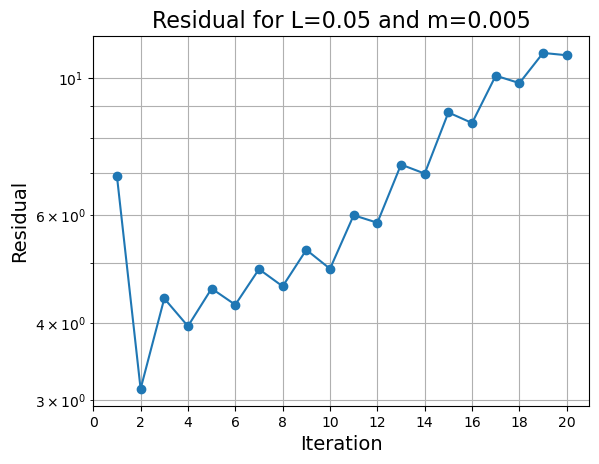

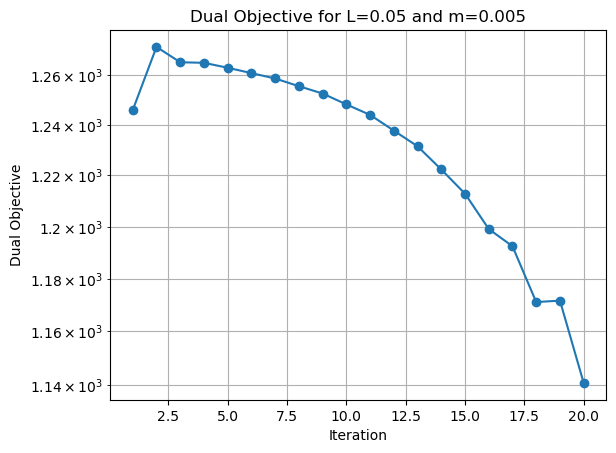

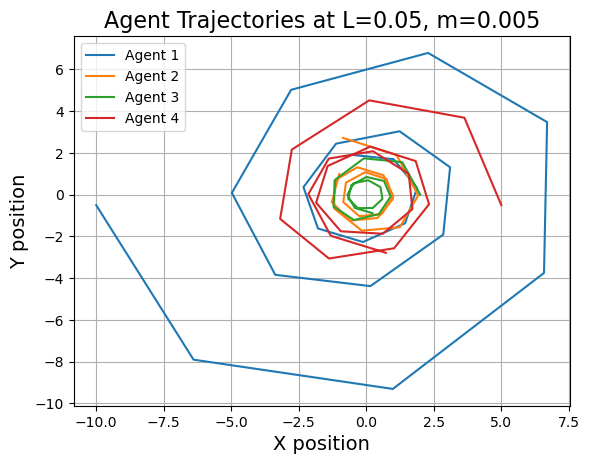

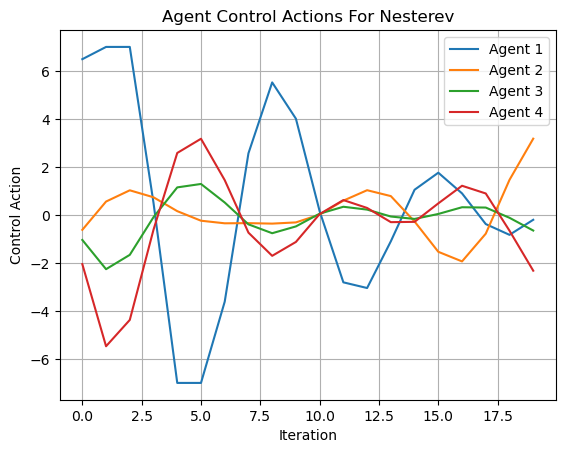

In [5]:
# Use Dual Decomposition/Subgradient Method with Nesterov method
def dual_subgradient_optimize_nesterov(L=1, m=1, stop_condition=1e-3, plot_convergence=True, plot_trajectories=True, strong_convexity=True):
    #initialize the lambda values and the xf at zero 
    lambdas = [np.zeros(np.shape(x01)) for _ in range(n_agents)]
    prev_lambdas = [np.zeros(np.shape(x01)) for _ in range(n_agents)] #list to hold the last iteration's lambdas. Start @ same as actual lambdas
    xf = np.zeros(np.shape(x01))

    #initialize the variables for nesterov's method: 
    if strong_convexity: 
        alpha = 1/L
        beta = (np.sqrt(L/m)-1)/(np.sqrt(L/m)+1)
    else: 
        alpha = 1/L
        theta_k = 0
        beta = 0 
    
    #variables for data storage
    residuals = np.zeros((1, Tfinal))
    dual_objs = np.zeros((1, Tfinal))
    
    #iterate over all timesteps
    for k in range(Tfinal): 
        
        #Variables we want to save for each agent @ each iteration 
        xf_list = np.zeros((np.size(xf),4))
        dual_obj = 0
        #iterate over all agents 
        for agent_i in range(n_agents):
            #solve the subproblem for the particular agent
            lambda_i = lambdas[agent_i]
            u_i_sub, x_i_sub, xf_sub = solve_subproblem(agent_i, xf, lambda_i, Tfinal)

            #update the list variables
            xf_list[:, agent_i] = xf_sub 

            #calculate the dual objective for the given agent
            for t in range(Tfinal): 
                dual_obj += u_i_sub[:, t].T @ u_i_sub[:, t]
            for t in range(Tfinal): 
                dual_obj += x_i_sub[:, t].T @ x_i_sub[:, t]
            dual_obj += lambda_i.T @ xf_sub
       
        #updae the xf variable
        xf = np.mean(xf_list, 1) #mean across collumns
        #now update the residual 
        #residual = np.max([np.abs(xf_list[:,xf_i] - xf) for xf_i in range(np.size(xf_list, 1))])
        residual = np.max([np.linalg.norm(xf_list[:,xf_i] - xf)/np.linalg.norm(xf) for xf_i in range(np.size(xf_list, 1))])
        residuals[:, k] = residual

        if residual <= stop_condition:
            break 

        #Log the dual objective for all agents: 
        dual_objs[:, k] = dual_obj

        #find the updated lambda for each agent
        lambda1_sums = 0
        lambda2_sums = 0

        #now loop through using Nesterov's method
        new_lambdas = [np.zeros(np.shape(x01)) for _ in range(n_agents)] #list to hold new lambdas as intermediate for switching old/current lambdas

        for i in range(n_agents):
            lambda_inter = lambdas[i] + beta * (lambdas[i]-prev_lambdas[i])
            #need to find the gradient for lambda_inter: 
            _, _, xf_inter = solve_subproblem(i, xf, lambda_inter, Tfinal)
            g_i = xf_inter.reshape((2,1)) - xf.reshape((2,1)) #Subgradient of dual problem
            new_lambdas[i] = lambda_inter + alpha * g_i #update lambda (Note that because we are maximizing this problem, it's gradient ascent)

            #save some variables for projection onto the feasible set
            lambda1_sums += new_lambdas[i][0]
            lambda2_sums += new_lambdas[i][1]

        #Project the lambda back onto the possible values (sum of lambdas must be zero for each component of lambda)
        for l_idx in range(n_agents):
            new_lambdas[l_idx][0] -= lambda1_sums/n_agents
            new_lambdas[l_idx][1] -= lambda2_sums/n_agents

        #preventing issues with shallow copying 
        prev_lambdas = [lam.copy() for lam in lambdas]
        lambdas = [new.copy() for new in new_lambdas]

        #Double check that all the lambdas sum to 0 
        #print("Sum of Lambdas is: ", lambdas[0] + lambdas[1] +lambdas[2] +lambdas[3])

    #plot convergence results 
    if plot_convergence: 
        # Logarithmic error sequence for residuals
        plt.figure()
        plt.semilogy(np.arange(1, k+2), residuals.flatten()[:k+1], marker='o')
        plt.xlabel('Iteration', size=14)
        plt.ylabel('Residual', size=14)
        plt.title(f'Residual for L={L} and m={m}', size=16)
        plt.xticks(np.arange(0, Tfinal+1, 2))
        plt.savefig(f"nesterov_residual_L{L}_m{m}.pdf", format="pdf")
        plt.grid(True, which='both', axis='both')

        # Logarithmic error sequence for dual objective
        plt.figure()
        plt.semilogy(np.arange(1, k+2), dual_objs.flatten()[:k+1], marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Dual Objective')
        plt.title(f'Dual Objective for L={L} and m={m}')
        plt.grid(True, which='both', axis='both')

        plt.show()

    #recreate the trajectories using the lambdas: 
    ui_1, x_i_1, _ = solve_subproblem(0, xf, lambdas[0], Tfinal)
    ui_2, x_i_2, _ = solve_subproblem(1, xf, lambdas[1], Tfinal)
    ui_3, x_i_3, _ = solve_subproblem(2, xf, lambdas[2], Tfinal)
    ui_4, x_i_4, _ = solve_subproblem(3, xf, lambdas[3], Tfinal)

    if plot_trajectories: 
        # static plot of trajectories
        plt.figure()
        plt.plot(x_i_1[0, :], x_i_1[1, :], label='Agent 1') #, marker='o'
        plt.plot(x_i_2[0, :], x_i_2[1, :], label='Agent 2') # , marker='s'
        plt.plot(x_i_3[0, :], x_i_3[1, :], label='Agent 3') # , marker='^'
        plt.plot(x_i_4[0, :], x_i_4[1, :], label='Agent 4') # , marker='x'
        plt.xlabel('X position', size=14)
        plt.ylabel('Y position', size=14)
        plt.title(f'Agent Trajectories at L={L}, m={m}', size=16)
        plt.legend()
        plt.grid(True)
        plt.savefig(f"nesterov_traj_L{L}_m{m}.pdf", format="pdf")
        plt.show()

        plt.figure()
        #print(np.size(ui_1))
        plt.plot(np.arange(0,np.size(ui_1)), ui_1[0, :], label='Agent 1') #, marker='o'
        plt.plot(np.arange(0,np.size(ui_2)), ui_2[0, :], label='Agent 2') # , marker='s'
        plt.plot(np.arange(0,np.size(ui_3)), ui_3[0, :], label='Agent 3') # , marker='^'
        plt.plot(np.arange(0,np.size(ui_4)), ui_4[0, :], label='Agent 4') # , marker='x'
        plt.xlabel('Iteration')
        plt.ylabel('Control Action')
        plt.title('Agent Control Actions For Nesterev')
        plt.legend()
        plt.grid(True)
        plt.show()

    return k, residuals.flatten()[:k+1], dual_objs.flatten()[:k+1], np.array([ui_1, ui_2, ui_3, ui_4]), np.array([x_i_1, x_i_2, x_i_3, x_i_4])

L1 = 10; m1=0.05
L2 = 1; m2=0.0575
L3 = 0.2; m3=0.055
L4 = 0.077; m4=0.04
L5 = 0.05; m5=0.075

k_final1_n, residuals1_n, dual_costs1_n, _, _ = dual_subgradient_optimize_nesterov(L=L1, m=m1, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False, strong_convexity=True)
k_final2_n, residuals2_n, dual_costs2_n, _, _ = dual_subgradient_optimize_nesterov(L=L2, m=m2, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False, strong_convexity=True)
k_final3_n, residuals3_n, dual_costs3_n, _, _ = dual_subgradient_optimize_nesterov(L=L3, m=m3, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False, strong_convexity=True)
k_final4_n, residuals4_n, dual_costs4_n, _, _ = dual_subgradient_optimize_nesterov(L=L4, m=m4, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False, strong_convexity=True)
k_final5_n, residuals5_n, dual_costs5_n, _, _ = dual_subgradient_optimize_nesterov(L=L5, m=m5, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False, strong_convexity=True)

_, _, _, _, _ = dual_subgradient_optimize_nesterov(L=0.05, m=0.005 , stop_condition=1e-6, plot_convergence=True, plot_trajectories=True, strong_convexity=True)



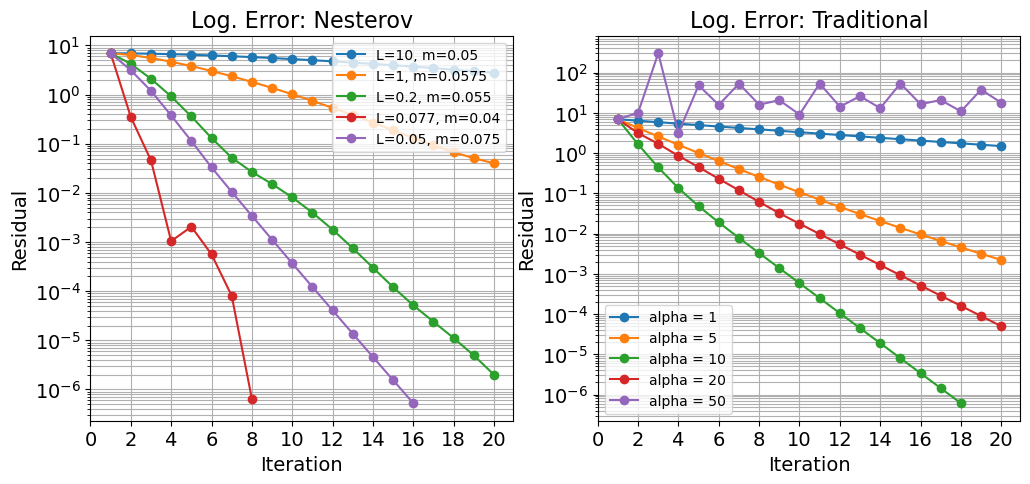

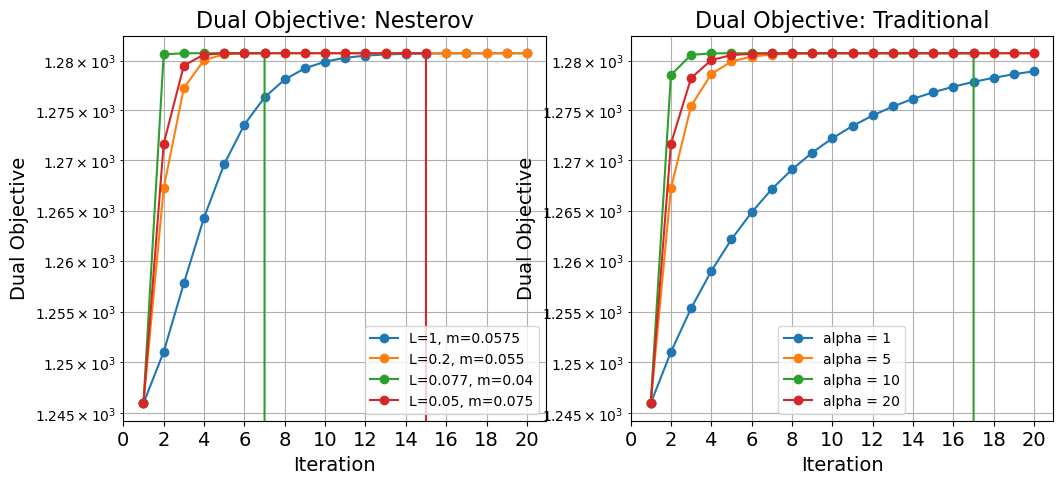

In [6]:
# Logarithmic error sequence for residuals(Nesterov Accelerated) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.semilogy(np.arange(1, k_final1_n+2), residuals1_n, marker='o', label=f"L={L1}, m={m1}")
ax1.semilogy(np.arange(1, k_final2_n+2), residuals2_n, marker='o', label=f"L={L2}, m={m2}")
ax1.semilogy(np.arange(1, k_final3_n+2), residuals3_n, marker='o', label=f"L={L3}, m={m3}")
ax1.semilogy(np.arange(1, k_final4_n+2), residuals4_n, marker='o', label=f"L={L4}, m={m4}")
ax1.semilogy(np.arange(1, k_final5_n+2), residuals5_n, marker='o', label=f"L={L5}, m={m5}")
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_title(f'Log. Error: Nesterov', fontsize=16)
ax1.legend(loc="upper right")
ax1.grid(True, which='both', axis='both')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xticks(np.arange(0, Tfinal+1, 2))

# Logarithmic error sequence for residuals(Constant step)
ax2.semilogy(np.arange(1, k_final1+2), residuals1_cs, marker='o', label=f"alpha = {alpha1}")
ax2.semilogy(np.arange(1, k_final2+2), residuals2_cs, marker='o', label=f"alpha = {alpha2}")
ax2.semilogy(np.arange(1, k_final3+2), residuals3_cs, marker='o', label=f"alpha = {alpha3}")
ax2.semilogy(np.arange(1, k_final4+2), residuals4_cs, marker='o', label=f"alpha = {alpha4}")
ax2.semilogy(np.arange(1, k_final5+2), residuals5_cs, marker='o', label=f"alpha = {alpha5}")
ax2.set_xlabel('Iteration', fontsize=14)
ax2.set_ylabel('Residual', fontsize=14)
ax2.set_title(f'Log. Error: Traditional', fontsize=16)
ax2.legend()
ax2.grid(True, which='both', axis='both')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xticks(np.arange(0, Tfinal+1, 2))
plt.savefig(f"nesterov_residual_comparison.pdf", format="pdf")
plt.show()

# Dual Objective logarithmic error sequence for nesterov-accelerated system
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#ax1.semilogy(np.arange(0, k_final1_n+1), dual_costs1_n, marker='o', label=f"L={L1}, m={m1}")
ax1.semilogy(np.arange(1, k_final2_n+2), dual_costs2_n, marker='o', label=f"L={L2}, m={m2}")
ax1.semilogy(np.arange(1, k_final3_n+2), dual_costs3_n, marker='o', label=f"L={L3}, m={m3}")
ax1.semilogy(np.arange(1, k_final4_n+2), dual_costs4_n, marker='o', label=f"L={L4}, m={m4}")
ax1.semilogy(np.arange(1, k_final5_n+2), dual_costs5_n, marker='o', label=f"L={L5}, m={m5}")
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Dual Objective', fontsize=14)
ax1.set_title("Dual Objective: Nesterov", fontsize=16)
ax1.legend()
ax1.grid(True, which='both', axis='both')
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xticks(np.arange(0, Tfinal+1, 2))

# Dual Objective logarithmic error sequence for constant-step function
ax2.semilogy(np.arange(1, k_final1+2), dual_costs1_cs, marker='o', label=f"alpha = {alpha1}")
ax2.semilogy(np.arange(1, k_final2+2), dual_costs2_cs, marker='o', label=f"alpha = {alpha2}")
ax2.semilogy(np.arange(1, k_final3+2), dual_costs3_cs, marker='o', label=f"alpha = {alpha3}")
ax2.semilogy(np.arange(1, k_final4+2), dual_costs4_cs, marker='o', label=f"alpha = {alpha4}")
#ax2.semilogy(np.arange(0, k_final5+1), dual_costs5_cs, marker='o', label=f"alpha = {alpha5}")
ax2.set_xlabel('Iteration', fontsize=14)
ax2.set_ylabel('Dual Objective', fontsize=14)
ax2.set_title("Dual Objective: Traditional", fontsize=16)
ax2.legend()
ax2.grid(True, which='both', axis='both')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xticks(np.arange(0, Tfinal+1, 2))
plt.savefig(f"nesterov_dual_comparison.pdf", format="pdf")




### Part D: 
Consider the standard incremental subgradient method, and the following consensus matrix between the agents(see assignment pdf)

Implement a combined consensus/incremental subgradient approach and investigate the effect of the number of consensus steps in each subgradient iteration on the con- vergence rate.

In [7]:
W = np.array([[0.75, 0.25, 0, 0],
              [0.25, 0.5, 0.25, 0],
              [0, 0.25, 0.5, 0.25],
              [0, 0, 0.25, 0.75]]) #from assignment pdf

# Use Dual Decomposition/Subgradient Method with consensus updates
def dual_subgradient_consensus_optimization(alpha=0.1, stop_condition=1e-3, consensus_rounds=10, plot_convergence=True, plot_trajectories=True, diminishing_step=False):
    #initialize the lambda values and the xf at zero 
    lambdas = [np.zeros(np.shape(x01)) for _ in range(n_agents)]
    #xf = np.zeros(np.shape(x01))
    xf = np.array([[(x01[0] + x02[0] +x03[0] +x04[0])/4],[(x01[1] + x02[1] +x03[1] +x04[1])/4]])

    #variables for data storage
    residuals = np.zeros((1, Tfinal))
    dual_objs = np.zeros((1, Tfinal))
    
    #iterate over all timesteps
    for k in range(Tfinal): 
        
        #Variables we want to save for each agent @ each iteration 
        xf_list = np.zeros((np.size(xf),4))
        dual_obj = 0
        #iterate over all agents 
        for agent_i in range(n_agents):
            #solve the subproblem for the particular agent
            lambda_i = lambdas[agent_i]
            u_i_sub, x_i_sub, xf_sub = solve_subproblem(agent_i, xf, lambda_i, Tfinal)

            #update the list variables
            xf_list[:, agent_i] = xf_sub 

            # Calculate the dual objective for the particular agent
            for t in range(Tfinal): 
                dual_obj += u_i_sub[:, t].T @ u_i_sub[:, t]
            for t in range(Tfinal): 
                dual_obj += x_i_sub[:, t].T @ x_i_sub[:, t]
            dual_obj += lambda_i.T @ xf_sub

        #updae the xf variable w/ the consensus matrix
        xf_avg = np.mean(xf_list, 1)
        xf_consensus = xf_list.copy().T 
        for i in range(consensus_rounds): 
            xf_consensus = W.dot(xf_consensus)

        xf_final = xf_consensus.copy().T 

        #now update the residual 
        xf_opt = np.mean(xf_list, 1)
        residual = np.max([np.linalg.norm(xf_list[:,xf_i] - xf_opt)/np.linalg.norm(xf_opt) for xf_i in range(np.size(xf_list, 1))])

        residuals[:, k] = residual

        if residual <= stop_condition:

            break 

        #and log it: 
        dual_objs[:, k] = dual_obj

        #find the updated lambda for each agent
        lambda1_sums = 0
        lambda2_sums = 0

        if diminishing_step: 
            if k == 0: 
                alpha_i = alpha
            else:
                alpha_i = alpha / k
            for i in range(n_agents):
                g_i = xf_list[:, i].reshape((2,1)) - xf_final[:,i].reshape((2,1))  #Subgradient of dual problem
                lambdas[i] = lambdas[i] + alpha_i * g_i #update lambda w/ changing step size

        else: 
            for i in range(n_agents):
                g_i = xf_list[:, i].reshape((2,1)) - xf_final[:,i].reshape((2,1)) #Subgradient of dual problem
                lambdas[i] = lambdas[i] + alpha * g_i #update lambda (Note that because we are maximizing this problem, it's gradient ascent)

                #save some variables for projection onto the feasible set
                lambda1_sums += lambdas[i][0]
                lambda2_sums += lambdas[i][1]

        #Project the lambda back onto the possible values (sum of lambdas must be zero for each component of lambda)
        for l_idx in range(n_agents):
            lambdas[l_idx][0] -= lambda1_sums/n_agents
            lambdas[l_idx][1] -= lambda2_sums/n_agents
            
        #Double check that all the lambdas sum to 0 
        #print("Sum of Lambdas is: ", lambdas[0] + lambdas[1] +lambdas[2] +lambdas[3])

    #plot convergence results 
    if plot_convergence: 
        # Logarithmic error sequence for residuals
        plt.figure()
        plt.semilogy(np.arange(1, k+2), residuals.flatten()[:k+1], marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Residual')
        plt.title(f'Residual for step size {alpha}')
        plt.grid(True, which='both', axis='both')

        # Logarithmic error sequence for dual objective
        plt.figure()
        plt.semilogy(np.arange(1, k+2), dual_objs.flatten()[:k+1], marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('Dual Objective')
        plt.title(f'Dual Objective for step size {alpha}')
        plt.grid(True, which='both', axis='both')

        plt.show()

    #recreate the trajectories using the lambdas: 
    ui_1, x_i_1, _ = solve_subproblem(0, xf, lambdas[0], Tfinal)
    ui_2, x_i_2, _ = solve_subproblem(1, xf, lambdas[1], Tfinal)
    ui_3, x_i_3, _ = solve_subproblem(2, xf, lambdas[2], Tfinal)
    ui_4, x_i_4, _ = solve_subproblem(3, xf, lambdas[3], Tfinal)

    if plot_trajectories: 
        # static plot of trajectories
        plt.figure()
        plt.plot(x_i_1[0, :], x_i_1[1, :], label='Agent 1') 
        plt.plot(x_i_2[0, :], x_i_2[1, :], label='Agent 2') 
        plt.plot(x_i_3[0, :], x_i_3[1, :], label='Agent 3') 
        plt.plot(x_i_4[0, :], x_i_4[1, :], label='Agent 4') 
        plt.plot(x_i_1[0, -1], x_i_1[1, -1], marker='o', label='Final Position')
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.title('Agent Trajectories For Decentralized Problem')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        #print(np.size(ui_1))
        plt.plot(np.arange(0,np.size(ui_1)), ui_1[0, :], label='Agent 1') #, marker='o'
        plt.plot(np.arange(0,np.size(ui_2)), ui_2[0, :], label='Agent 2') # , marker='s'
        plt.plot(np.arange(0,np.size(ui_3)), ui_3[0, :], label='Agent 3') # , marker='^'
        plt.plot(np.arange(0,np.size(ui_4)), ui_4[0, :], label='Agent 4') # , marker='x'
        plt.xlabel('Iteration')
        plt.ylabel('Control Action')
        plt.title('Agent Control Actions For Decentralized Problem')
        plt.legend()
        plt.grid(True)
        plt.show()

    return k, residuals.flatten()[:k+1], dual_objs.flatten()[:k+1], np.array([ui_1, ui_2, ui_3, ui_4]), np.array([x_i_1, x_i_2, x_i_3, x_i_4])

alpha_consensus = 10
num_rounds_1 = 0
num_rounds_2 = 1
num_rounds_3 = 5
num_rounds_4 = 10
num_rounds_5 = 25

k_stop_1, residuals_1, dual_objs_1, _, _ = dual_subgradient_consensus_optimization(alpha=alpha_consensus, consensus_rounds=num_rounds_1, stop_condition=1e-9, plot_convergence=False, plot_trajectories=False)
k_stop_2, residuals_2, dual_objs_2, _, _ = dual_subgradient_consensus_optimization(alpha=alpha_consensus, consensus_rounds=num_rounds_2, stop_condition=1e-9, plot_convergence=False, plot_trajectories=False)
k_stop_3, residuals_3, dual_objs_3, _, _ = dual_subgradient_consensus_optimization(alpha=alpha_consensus, consensus_rounds=num_rounds_3, stop_condition=1e-9, plot_convergence=False, plot_trajectories=False)
k_stop_4, residuals_4, dual_objs_4, _, _ = dual_subgradient_consensus_optimization(alpha=alpha_consensus, consensus_rounds=num_rounds_4, stop_condition=1e-9, plot_convergence=False, plot_trajectories=False)
k_stop_5, residuals_5, dual_objs_5, _, _ = dual_subgradient_consensus_optimization(alpha=alpha_consensus, consensus_rounds=num_rounds_5, stop_condition=1e-9, plot_convergence=False, plot_trajectories=False)



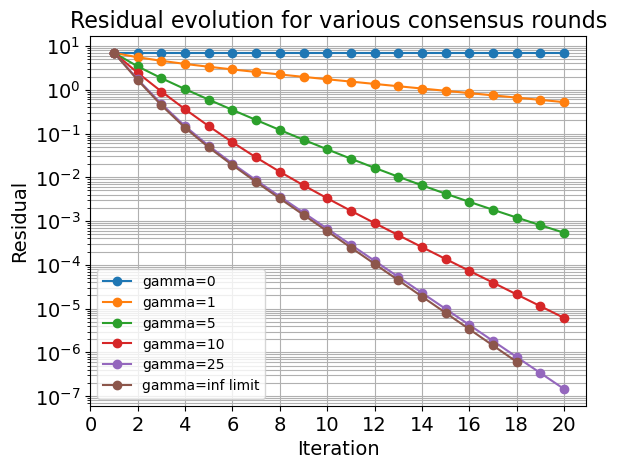

In [8]:
# Logarithmic error sequence for residuals
plt.figure()
plt.semilogy(np.arange(1, k_stop_1+2), residuals_1, marker='o', label=f"gamma={num_rounds_1}")
plt.semilogy(np.arange(1, k_stop_2+2), residuals_2, marker='o', label=f"gamma={num_rounds_2}")
plt.semilogy(np.arange(1, k_stop_3+2), residuals_3, marker='o', label=f"gamma={num_rounds_3}")
plt.semilogy(np.arange(1, k_stop_4+2), residuals_4, marker='o', label=f"gamma={num_rounds_4}")
plt.semilogy(np.arange(1, k_stop_5+2), residuals_5, marker='o', label=f"gamma={num_rounds_5}")
plt.semilogy(np.arange(1, k_final3+2), residuals3_cs, marker='o', label=f"gamma=inf limit")
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title(f'Residual evolution for various consensus rounds', fontsize=16)
plt.xticks(np.arange(0, k_stop_1+2, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid(True, which='both', axis='both')
plt.savefig(f"consensus_comparison.pdf", format="pdf")

### Part E: (EXTRA CREDIT PROBLEM)
For extra points (and a good learning experience), consider replacing the linear input constraint with the following quadratic limitation on the total control energy

$$
\sum_t u_i(t)^Tu_i(t) ≤ 5u_{max}^2, \forall i
$$


You may need to have access to solvers that are able to solve the resulting quadratically constrained quadratic programs (QCQP), such as Yalmip using the Gurobi solver.

# Question 2

### Part A: 
Consider the multi-agent coordination formulation in Problem 1 and implement a consensus ADMM approach (see ADMM lecture slides) to solve this problem. 

Show a plot that demonstrates the convergence of the optimization process (in terms of a logarithmic error sequence). 

Show a plot of the resulting agent state trajectories after convergence, and compare with the centralized optimal solution.

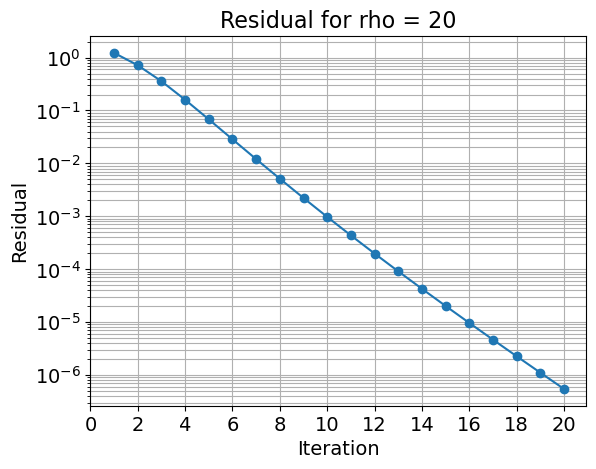

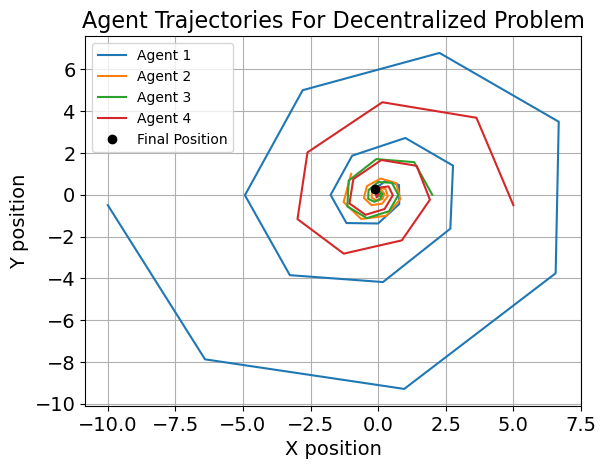

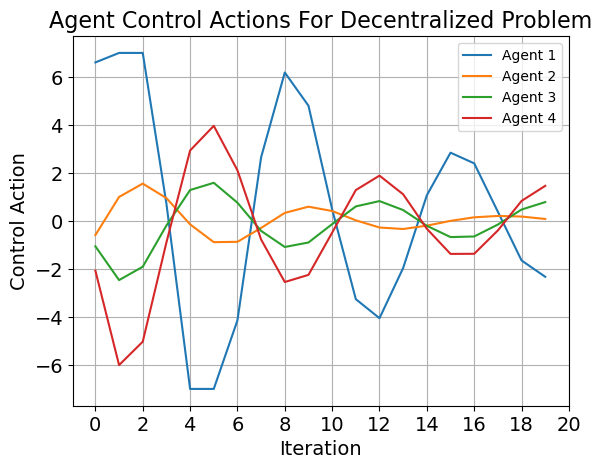

In [9]:
# Use ADMM to optimize the problem(see ADMM lecture slide 21)
def ADMM_optimize(rho=1, stop_condition=1e-3, plot_convergence=True, plot_trajectories=True):
    #initialize the lambda values and the xf at zero 
    lambdas = [np.zeros(np.shape(x01)) for _ in range(n_agents)]
    #xf = np.zeros(np.shape(x01))
    xf = np.array([[(x01[0] + x02[0] +x03[0] +x04[0])/4],[(x01[1] + x02[1] +x03[1] +x04[1])/4]])

    #variables for data storage
    residuals = np.zeros((1, Tfinal))
    dual_objs = np.zeros((1, Tfinal))
    
    #iterate over all timesteps
    for k in range(Tfinal): 
        
        #Variables we want to save for each agent @ each iteration 
        xf_list = np.zeros((np.size(xf),4))
        dual_obj = 0
        #iterate over all agents 
        for agent_i in range(n_agents):
            #solve the subproblem for the particular agent
            lambda_i = lambdas[agent_i]
            u_i_sub, x_i_sub, xf_sub = solve_subproblem_ADMM(agent_i, xf, lambda_i, Tfinal, rho=rho)

            #update the list variables
            xf_list[:, agent_i] = xf_sub 

            # Calculate the dual objective for the particular agent
            for t in range(Tfinal): 
                dual_obj += u_i_sub[:, t].T @ u_i_sub[:, t]
            for t in range(Tfinal): 
                dual_obj += x_i_sub[:, t].T @ x_i_sub[:, t]
            
            diff = (xf_sub.reshape((2,1)) - xf.reshape((2,1)))
            dual_obj += lambda_i.T @ diff + (rho/2) * diff.T @ diff

        #updae the xf variable

        #Do the ADMM update(see slide 21 of ADMM lecture): 
        xf_next = np.zeros((2,1))
        for i in range(n_agents):
            xf_next += xf_list[:, i].reshape((2,1)) + 1/rho * lambdas[i].reshape((2,1))
        xf = xf_next/4 

        #now update the residual(using the norm of the )
        xf_opt = np.mean(xf_list, 1)
        residual = np.max([np.linalg.norm(xf_list[:,xf_i] - xf_opt)/np.linalg.norm(xf_opt) for xf_i in range(np.size(xf_list, 1))])

        residuals[:, k] = residual

        if residual <= stop_condition:
            break 

        #and log it: 
        dual_objs[:, k] = dual_obj

        #find the updated lambda for each agent
        lambda1_sums = 0
        lambda2_sums = 0

        
        for i in range(n_agents):
            g_i = xf_list[:, i].reshape((2,1)) - xf.reshape((2,1)) #Subgradient of dual problem
            lambdas[i] = lambdas[i] + rho * g_i #update lambda (Note that because we are maximizing this problem, it's gradient ascent)

            
        #Double check that all the lambdas sum to 0 
        #print("Sum of Lambdas is: ", lambdas[0] + lambdas[1] +lambdas[2] +lambdas[3])

    #plot convergence results 
    if plot_convergence: 
        # Logarithmic error sequence for residuals
        plt.figure()
        plt.semilogy(np.arange(1, k+2), residuals.flatten()[:k+1], marker='o')
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Residual', fontsize=14)
        plt.title(f'Residual for rho = {rho}', fontsize=16)
        plt.xticks(np.arange(0, k_stop_1+2, 2), fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, which='both', axis='both')
        plt.savefig(f"admm_convergence _rho{rho}.pdf", format="pdf")

        #plotting the dual is not useful for comparison to other methods, as it has a different dual function

    #recreate the trajectories using the lambdas: 
    ui_1, x_i_1, _ = solve_subproblem(0, xf, lambdas[0], Tfinal)
    ui_2, x_i_2, _ = solve_subproblem(1, xf, lambdas[1], Tfinal)
    ui_3, x_i_3, _ = solve_subproblem(2, xf, lambdas[2], Tfinal)
    ui_4, x_i_4, _ = solve_subproblem(3, xf, lambdas[3], Tfinal)

    if plot_trajectories: 
        # static plot of trajectories
        plt.figure()
        plt.plot(x_i_1[0, :], x_i_1[1, :], label='Agent 1') #, marker='o'
        plt.plot(x_i_2[0, :], x_i_2[1, :], label='Agent 2') # , marker='s'
        plt.plot(x_i_3[0, :], x_i_3[1, :], label='Agent 3') # , marker='^'
        plt.plot(x_i_4[0, :], x_i_4[1, :], label='Agent 4') # , marker='x'
        plt.plot(x_i_1[0, -1], x_i_1[1, -1], 'ko', label='Final Position')
        plt.xlabel('X position', fontsize=14)
        plt.ylabel('Y position', fontsize=14)
        plt.title('Agent Trajectories For Decentralized Problem', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.savefig(f"admm_trajectory_rho{rho}.pdf", format="pdf")
        plt.show()

        plt.figure()
        #print(np.size(ui_1))
        plt.plot(np.arange(0,np.size(ui_1)), ui_1[0, :], label='Agent 1') #, marker='o'
        plt.plot(np.arange(0,np.size(ui_2)), ui_2[0, :], label='Agent 2') # , marker='s'
        plt.plot(np.arange(0,np.size(ui_3)), ui_3[0, :], label='Agent 3') # , marker='^'
        plt.plot(np.arange(0,np.size(ui_4)), ui_4[0, :], label='Agent 4') # , marker='x'
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Control Action', fontsize=14)
        plt.title('Agent Control Actions For Decentralized Problem', fontsize=16)
        plt.xticks(np.arange(0, k_stop_1+2, 2), fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.savefig(f"admm_controlActions_rho{rho}.pdf", format="pdf")
        plt.show()

    return k, residuals.flatten()[:k+1], dual_objs.flatten()[:k+1], np.array([ui_1, ui_2, ui_3, ui_4]), np.array([x_i_1, x_i_2, x_i_3, x_i_4])

def solve_subproblem_ADMM(i, xf, lambda_i, Tf, rho):
    #make sure you have all the right dynamics variables
    A_i = A_list[i]
    B_i = B_list[i]
    x0_i = init_x_list[i]

    #Decision Variables
    u_i = cvx.Variable((np.size(B1,1), Tf))
    x_i = cvx.Variable((np.size(A1,1), Tf + 1))

    #add constraints
    constraints = []
    #constraint 0: Start @ initial position
    constraints.append(x_i[:,0].reshape(np.shape(x0_i)) == x0_i)

    #constraint 1: x_k+1 = Ax_k + Bu_k 
    #Loop through all of the timesteps
    for k in range(Tf):
        constraints.append(x_i[:,k+1] == A_i @ x_i[:,k] + B_i @ u_i[:, k])
    
    #constraint 2: |u_k| < u_max
    for k in range(Tf):
        constraints.append(cvx.abs(u_i[:,k]) <= umax)

    #add objective function: 
    obj = 0
    for k in range(Tf):
        obj += cvx.sum_squares(x_i[:, k])
        obj += cvx.sum_squares(u_i[:, k])
    
    #add lagrangian(dual) term to obj 
    #print(lambda_i)
    #print(x_i[:,Tf])
    diff = (x_i[:, Tf].reshape((2,1)) - xf.reshape((2,1)))
    obj += lambda_i.T @ diff + rho/2 * cvx.sum_squares(diff)  #add the square of the euclidian norm 

    prob = cvx.Problem(cvx.Minimize(obj), constraints=constraints)
    prob.solve(solver=cvx.OSQP, verbose=False) #there are a bunch of arguments you can use with this 
    
    if prob.status == cvx.OPTIMAL:
        return u_i.value, x_i.value, x_i[:, Tf].value
    else: 
        print(f"SUBPROBLEM SOLUTION WAS NOT OPTIMAL FOR AGENT {i} using {xf}, {lambda_i}")
        return None, None, None

_, _, _, _, _ = ADMM_optimize(rho=20, stop_condition=1e-6)


### Part B: 
Investigate the effect of the ρ parameter on the convergence rate. Show the results using a logarithmic error sequence plot.

In [10]:
rho1 = 1
rho2 = 5
rho3 = 10
rho4 = 20
rho5 = 100
rho6 = 1000

k_stop_1, residuals_1, _, _, _ = ADMM_optimize(rho=rho1, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_stop_2, residuals_2, _, _, _ = ADMM_optimize(rho=rho2, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_stop_3, residuals_3, _, _, _ = ADMM_optimize(rho=rho3, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_stop_4, residuals_4, _, _, _ = ADMM_optimize(rho=rho4, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_stop_5, residuals_5, _, _, _ = ADMM_optimize(rho=rho5, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)
k_stop_6, residuals_6, _, _, _ = ADMM_optimize(rho=rho6, stop_condition=1e-6, plot_convergence=False, plot_trajectories=False)



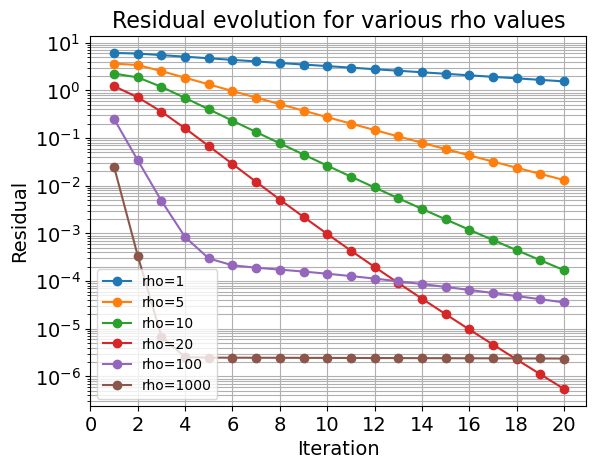

In [11]:
# Logarithmic error sequence for residuals
plt.figure()
plt.semilogy(np.arange(1, k_stop_1+2), residuals_1, marker='o', label=f"rho={rho1}")
plt.semilogy(np.arange(1, k_stop_2+2), residuals_2, marker='o', label=f"rho={rho2}")
plt.semilogy(np.arange(1, k_stop_3+2), residuals_3, marker='o', label=f"rho={rho3}")
plt.semilogy(np.arange(1, k_stop_4+2), residuals_4, marker='o', label=f"rho={rho4}")
plt.semilogy(np.arange(1, k_stop_5+2), residuals_5, marker='o', label=f"rho={rho5}")
plt.semilogy(np.arange(1, k_stop_6+2), residuals_6, marker='o', label=f"rho={rho6}")
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title(f'Residual evolution for various rho values', fontsize=16)
plt.legend()
plt.grid(True, which='both', axis='both')
plt.xticks(np.arange(0, k_stop_1+2, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("admm_error_sequence.pdf", format="pdf")